# <center> Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 3. Визуальный анализ данных и построение признаков

На 3 неделе мы займемся визуальным анализом данных и построением признаков. Сначала мы вместе построим и проанализируем несколько признаков, потом Вы сможете сами придумать и описать различные признаки. Задание имеет вид Peer-Review, так что творчество здесь активно приветствуется. Если задействуете IPython-виджеты, библиотеку Plotly, анимации и прочий интерактив, всем от этого будет только лучше.

**План 3 недели:**
 - Часть 1. Построение признаков и визуальный анализ данных
 - Часть 2. Визуальный анализ данных
 - Часть 3. Дальнейшее построение признаков
 

**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Поиск структуры в данных":**
   - [Задача визуализации](https://www.coursera.org/learn/unsupervised-learning/lecture/hlvlT/zadacha-vizualizatsii)
   - [Визуализация данных в sklearn](https://www.coursera.org/learn/unsupervised-learning/lecture/ityMo/vizualizatsiia-dannykh-v-sklearn)
   
**Также в задании будет использоваться библиотека Seaborn (ее можно дополнительно установить командой *conda install seaborn*), будет полезно обращаться к документациям [Matplotlib](http://matplotlib.org/users/) и [Seaborn](http://seaborn.pydata.org/), а также к примерам визуализации, описанным на StackOverflow.**



## Часть 1. Построение признаков

In [21]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import numpy as np
import pandas as pd
pd.set_option('display.max.columns', 25)
import pickle
#conda install seaborn
import seaborn as sns
from datetime import datetime
import itertools

In [20]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


**Создайте на основе функций *prepare_train_set* и *prepare_sparse_train_set_window*  новую – *prepare_train_set_with_fe*, (от "feature engineering"), создайте следующие 13 признаков:**
- time_diff1, ..., time_diff9 – промежутки между посещением 1 и 2 сайта, ..., 9 и 10 сайта в сессии (в секундах). Посещения сайтов не сторого упорядочены по времени, поэтому эти величины где-то могут быть отрицательными. Если сайтов в сессии меньше 10, разницы можно сделать нулевыми
- session_timespan – продолжительность сессии. Из-за того, что посещения сайтов не сторого упорядочены по времени, продолжительностью сессии будем считать разницу между максимальным и минимальным временем посещения сайтов в сессии (в секундах).
- #unique_sites – число уникальных сайтов в сессии 
- start_hour – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- day_of_week – день недели (то есть день недели в записи минимального timestamp среди десяти)

Функция должна возвращать новый DataFrame (как возвращала функция *prepare_train_set*), только признаков должно быть на 13 больше. Порядок, в котором добавляются признаки: *site1*, ... *site10*, *time_diff1*, ..., *time_diff9*, *session_timespan*, *#unique_sites*, *start_hour*,*day_of_week*,*target* (это видно и чуть ниже по тому, как функция вызывается).

In [2]:
def prepare_train_set_with_fe(csv_files_mask, site_freq_path, feature_names,
                                    session_length=10, window_size=10):
    
    train_data = np.array([np.zeros(len(feature_names))])
    site_freq = {}
    
    if site_freq_path != "":
        pkl_file = open(site_freq_path, 'rb')
        site_freq = pickle.load(pkl_file)
    else:
        return None
    
    for userfile in glob(csv_files_mask):
        data = pd.read_csv(userfile, header=None, names=['userid', 'timestamp', 'site'], \
                           parse_dates=[1], infer_datetime_format=True)
        user_id = data.userid[0]
        session_hash = {}
        
        for i in range (0, len(data), window_size):
            session = tuple(data[i:i+session_length].site.apply(lambda x: site_freq[x][0]))           
            if session not in session_hash:
                session_hash[session] = 1
                session = list(session)
                timestamps = list(data[i:i+session_length].timestamp)
                time_diff = [(timestamps[n+1] - timestamps[n]).total_seconds() for n in range(0, len(session)-1)]
                session_timespan = (max(timestamps) - min(timestamps)).total_seconds()
                num_unique_sites = len(set(session))
                start_hour = min(timestamps).hour
                day_of_week = min(timestamps).weekday()
                session.extend([0] * (session_length - len(session)) + time_diff + \
                               [0]*(session_length - len(time_diff) - 1) + \
                               [session_timespan, num_unique_sites, start_hour, day_of_week, user_id])
                train_data = np.concatenate((train_data, np.array([session])))
    
    train_data = np.delete(train_data, 0, 0)
    train_data = pd.DataFrame(train_data, columns=feature_names)
    return train_data

**Проверим функцию на игрушечном примере.**

In [3]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 'day_of_week', 'target']
train_data_toy  = prepare_train_set_with_fe('capstone_websites_data/3users_toy/*', 
                                   site_freq_path='capstone_websites_data/site_freq_3users.pkl',
                                   feature_names=feature_names, session_length=10)

In [4]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,1.0,2.0,3.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,287.0,1184.0,6278.0,186.0,0.0,0.0,0.0,0.0,0.0,7935.0,3.0,9.0,4.0,2.0
1,1.0,2.0,2.0,4.0,2.0,5.0,6.0,7.0,8.0,9.0,287.0,1184.0,6278.0,186.0,2.0,1.0,2.0,3.0,55.0,7998.0,8.0,9.0,4.0,1.0
2,1.0,5.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,3.0,55.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,2.0,12.0,4.0,1.0
3,10.0,5.0,2.0,5.0,2.0,5.0,5.0,7.0,11.0,10.0,287.0,1184.0,6278.0,186.0,2.0,1.0,2.0,3.0,55.0,7998.0,5.0,9.0,4.0,3.0
4,10.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,287.0,1184.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1471.0,3.0,12.0,4.0,3.0


**Примените функцию *prepare_train_set_with_fe* к данным по 10 пользователям, укажите session_length=10.**

In [5]:
%%time
train_data_10users = prepare_train_set_with_fe('capstone_websites_data/10users/*', 
                                   site_freq_path='capstone_websites_data/site_freq_10users.pkl',
                                   feature_names=feature_names, session_length=10)

CPU times: user 8.21 s, sys: 1.83 s, total: 10 s
Wall time: 10 s


In [6]:
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,1.0,2.0,3.0,4.0,5.0,1.0,2.0,4.0,5.0,3.0,3.0,2.0,41.0,1.0,1.0,0.0,0.0,0.0,0.0,48.0,5.0,13.0,4.0,128.0
1,3.0,6.0,7.0,8.0,6.0,8.0,7.0,8.0,9.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,3.0,6.0,13.0,4.0,128.0
2,3.0,9.0,7.0,3.0,10.0,11.0,8.0,8.0,10.0,8.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,8.0,2.0,13.0,6.0,13.0,4.0,128.0
3,8.0,7.0,3.0,3.0,11.0,3.0,3.0,12.0,12.0,13.0,0.0,8.0,18.0,47.0,11.0,18.0,137.0,17.0,26.0,282.0,6.0,13.0,4.0,128.0
4,13.0,9.0,10.0,12.0,12.0,13.0,12.0,12.0,14.0,15.0,46.0,14.0,31.0,1.0,13.0,17.0,1.0,10.0,6.0,139.0,6.0,13.0,4.0,128.0


**Примените функцию *prepare_train_set_with_fe* к данным по 150 пользователям, укажите session_length=10.**

In [7]:
%%time
train_data_150users = prepare_train_set_with_fe('capstone_websites_data/150users/*', 
                                   site_freq_path='capstone_websites_data/site_freq_150users.pkl',
                                   feature_names=feature_names, session_length=10)

CPU times: user 4min 12s, sys: 1min 24s, total: 5min 36s
Wall time: 5min 36s


In [8]:
train_data_150users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,1.0,1.0,2.0,3.0,3.0,4.0,5.0,4.0,4.0,4.0,15.0,200.0,102.0,61.0,15.0,0.0,6.0,7.0,23.0,429.0,5.0,8.0,2.0,580.0
1,6.0,7.0,8.0,8.0,6.0,9.0,10.0,11.0,10.0,12.0,3.0,0.0,1.0,6.0,1.0,0.0,1.0,0.0,0.0,12.0,7.0,8.0,2.0,580.0
2,9.0,13.0,14.0,9.0,12.0,11.0,15.0,15.0,16.0,17.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,92.0,0.0,94.0,8.0,8.0,2.0,580.0
3,17.0,2.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0,25.0,43.0,67.0,120.0,120.0,903.0,0.0,0.0,0.0,0.0,1253.0,10.0,8.0,2.0,580.0
4,21.0,26.0,27.0,23.0,25.0,28.0,29.0,30.0,31.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,10.0,8.0,2.0,580.0


**Сохраните в pickle-файлы *time_diff1*,..., *time_diff9, session_timespan, #unique_sites, start_hour* и *day_of_week* для 10 и 150 пользователей.**

In [9]:
new_features_10users = train_data_10users.iloc[:,10:-1]
new_features_150users = train_data_150users.iloc[:,10:-1]

In [169]:
with open('new_features_10users.pkl', 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)
with open('new_features_150users.pkl', 'wb') as new_features_150users_pkl:
    pickle.dump(new_features_150users, new_features_150users_pkl)

## Часть 2. Визуальный анализ данных

**Забавы ради, потехи для дадим пользователям имена и ассоциируем с ними цвета.**

In [10]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
train_data_10users['target'] = train_data_10users['target'].map(id_name_dict)

In [11]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

**1. Постройте гистограмму распределения длины сессии в секундах (*session_timespan*). Ограничьте по *x* значением 200 (иначе слишком тяжелый хвост). Сделайте гистограмму цвета *darkviolet*, подпишите оси по-русски.**

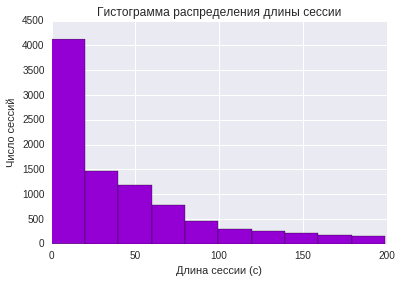

In [25]:
pyplot.xlabel(u'Длина сессии (с)')
pyplot.ylabel(u'Число сессий')
pyplot.title(u'Гистограмма распределения длины сессии')
train_data_10users[train_data_10users['session_timespan'] < 200]['session_timespan'].hist(color="darkviolet")
pyplot.show()

**2. Постройте гистограмму распределения числа уникальных сайтов в сессии (*#unique_sites*). Сделайте гистограмму цвета *aqua*, подпишите оси по-русски.**

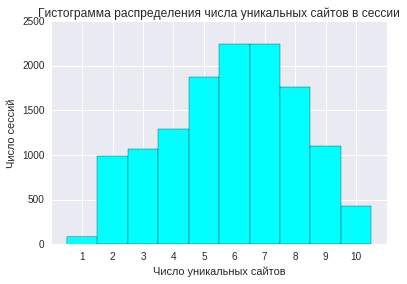

In [26]:
unique = np.unique(train_data_10users['#unique_sites']).astype(int)
bins = np.append(unique, unique[-1]+1) - 0.5

pyplot.xlabel(u'Число уникальных сайтов')
pyplot.ylabel(u'Число сессий')
pyplot.title(u'Гистограмма распределения числа уникальных сайтов в сессии')
train_data_10users['#unique_sites'].hist(color="aqua", bins=bins)
pyplot.gca().set(xticks = unique, xlim = [min(unique)-1, max(unique)+1])
pyplot.show()

**3. Постройте гистограммы распределения числа уникальных сайтов в сессии (*#unique_sites*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку – на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

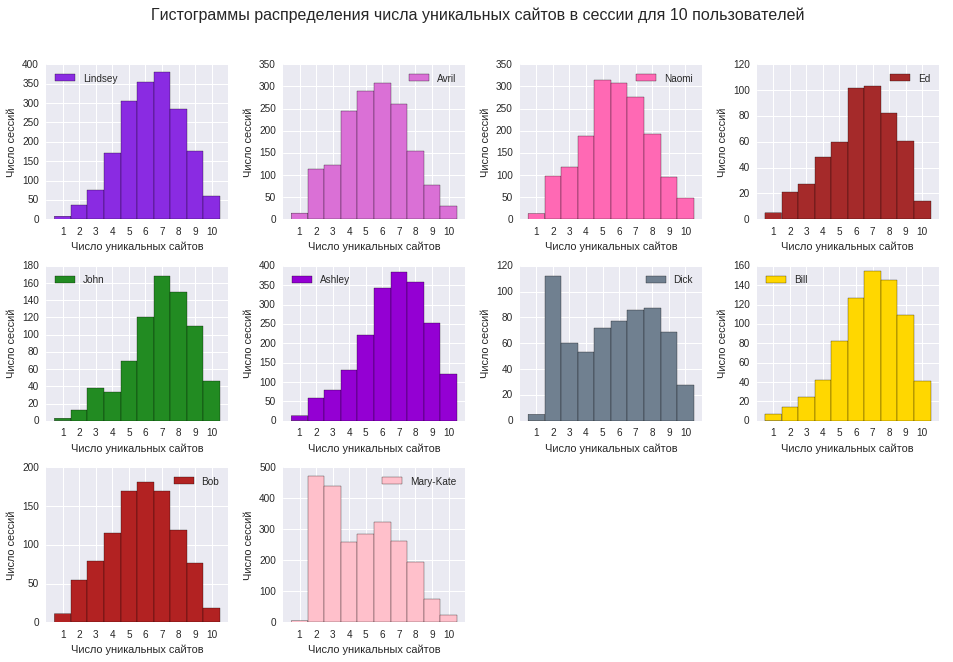

In [27]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.3)
user_names = id_name_dict.values()

unique = np.unique(train_data_10users['#unique_sites']).astype(int)
bins = np.append(unique, unique[-1]+1) - 0.5

for x, y in itertools.product(range(0, 3), range(0, 4)):
    if len(user_names):
        user_name = user_names.pop()
        axes[x, y].set_xlabel(u'Число уникальных сайтов')
        axes[x, y].set_ylabel(u'Число сессий')
        train_data_10users[train_data_10users.target == user_name]['#unique_sites'].hist(color=color_dic[user_name],\
                                                                          ax=axes[x, y], label=user_name, bins=bins)
        axes[x, y].legend(loc="best")
        axes[x, y].set(xticks = unique, xlim = [min(unique)-1, max(unique)+1])
axes[2, 2].axis('off')
axes[2, 3].axis('off')
pyplot.suptitle(u'Гистограммы распределения числа уникальных сайтов в сессии для 10 пользователей', fontsize=16)
pyplot.show()

# как вариант, можно и по-другому
#for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'target')): 
     #''' ВАШ КОД ЗДЕСЬ '''

**4. Постройте гистограмму распределения часа начала сессии (*start_hour*). Сделайте гистограмму цвета *darkgreen*, подпишите оси по-русски.**

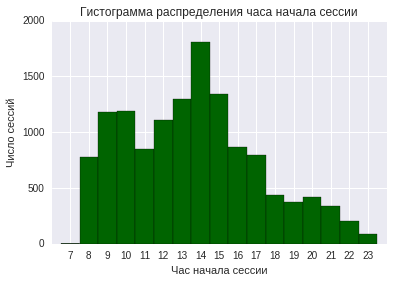

In [28]:
hours = np.unique(train_data_10users['start_hour']).astype(int)
bins = np.append(hours, hours[-1]+1) - 0.5

pyplot.xlabel(u'Час начала сессии')
pyplot.ylabel(u'Число сессий')
pyplot.title(u'Гистограмма распределения часа начала сессии')
train_data_10users['start_hour'].hist(color="darkgreen", bins=bins)
pyplot.gca().set(xticks = hours, xlim = [min(hours)-1, max(hours)+1])
pyplot.show()

**5. Постройте гистограммы распределения часа начала сессии (*start_hour*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку – на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

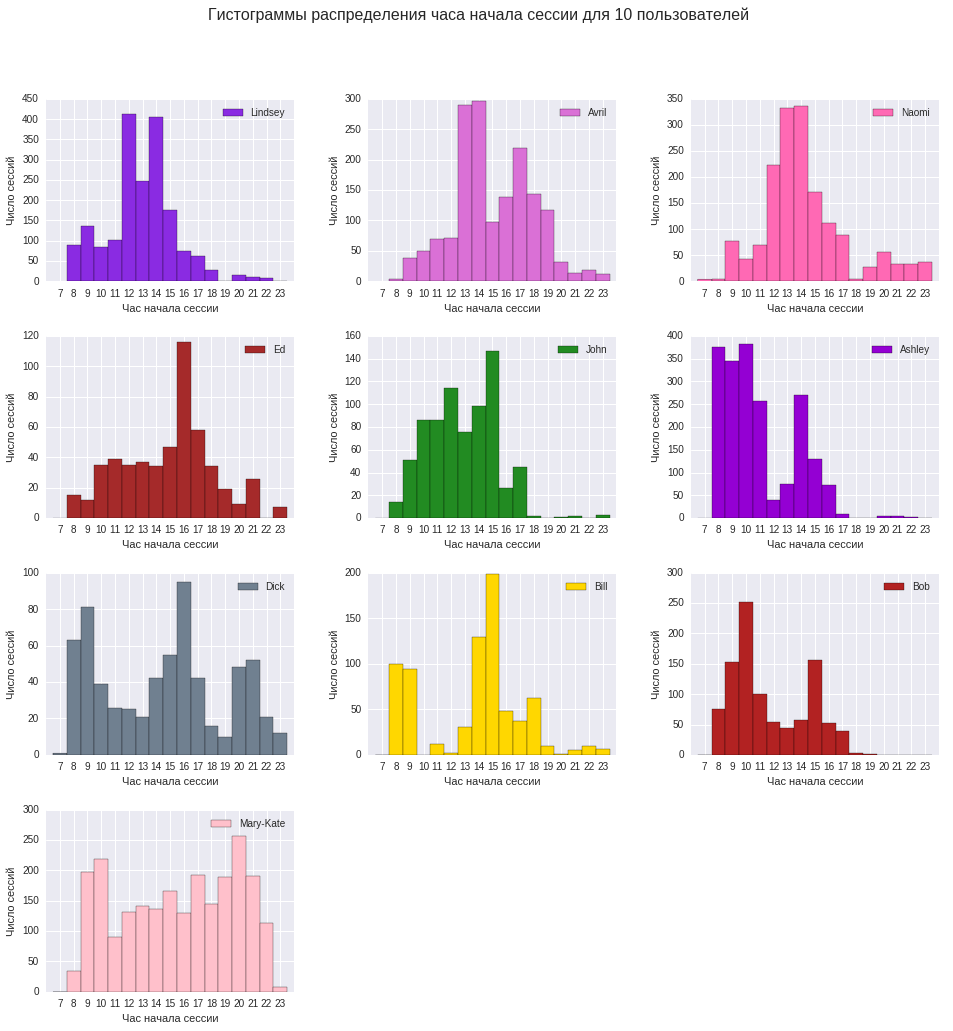

In [29]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(16, 16))
subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.3)
user_names = id_name_dict.values()

# возьмём одинаковые бины для всех гистограмм, чтобы удобнее было сравнивать
hours = np.unique(train_data_10users['start_hour']).astype(int)
bins = np.append(hours, hours[-1]+1) - 0.5 

for x, y in itertools.product(range(0, 4), range(0, 3)):
    if len(user_names):
        user_name = user_names.pop()
        axes[x, y].set_xlabel(u'Час начала сессии')
        axes[x, y].set_ylabel(u'Число сессий')
        
        train_data_10users[train_data_10users.target == user_name]['start_hour'].hist(color=color_dic[user_name],\
                                                                                    ax=axes[x, y], label=user_name,\
                                                                                     bins = bins)
        axes[x, y].set(xticks = hours, xlim = [min(hours)-1, max(hours)+1])
        
        axes[x, y].legend(loc="best")
axes[3, 1].axis('off')
axes[3, 2].axis('off')
pyplot.suptitle(u'Гистограммы распределения часа начала сессии для 10 пользователей', fontsize=16)
pyplot.show()

# как вариант, можно и по-другому
#for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'target')): 
     #''' ВАШ КОД ЗДЕСЬ '''

**6. Постройте гистограмму распределения дня недели, в который началась сессия (*day_of_week*). Сделайте гистограмму цвета *sienna*, подпишите оси по-русски.**

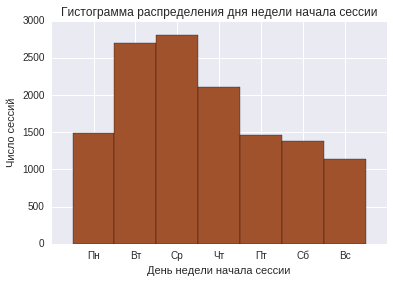

In [30]:
# Great explanation why it's better to use bincount:
# http://stackoverflow.com/questions/27083051/matplotlib-xticks-not-lining-up-with-histogram
pyplot.xlabel(u'День недели начала сессии')
pyplot.ylabel(u'Число сессий')
pyplot.title(u'Гистограмма распределения дня недели начала сессии')
counts = np.bincount(train_data_10users['day_of_week'].astype(int), minlength=7)
pyplot.gca().bar(range(7), counts, width=1, align='center', color="sienna")
pyplot.gca().set(xticks=range(7), xlim=[-1, 7], xticklabels=[u'Пн', u'Вт', u'Ср', u'Чт', u'Пт', u'Сб', u'Вс'])
pyplot.show()

**7. Постройте гистограммы распределения дня недели, в который началась сессия (*day_of_week*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Измените метки по оси *X* на ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] – метод *set_xticklabels*. Пометьте легендой каждую картинку – на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите по-русски название каждой из 10 гистограмм.**

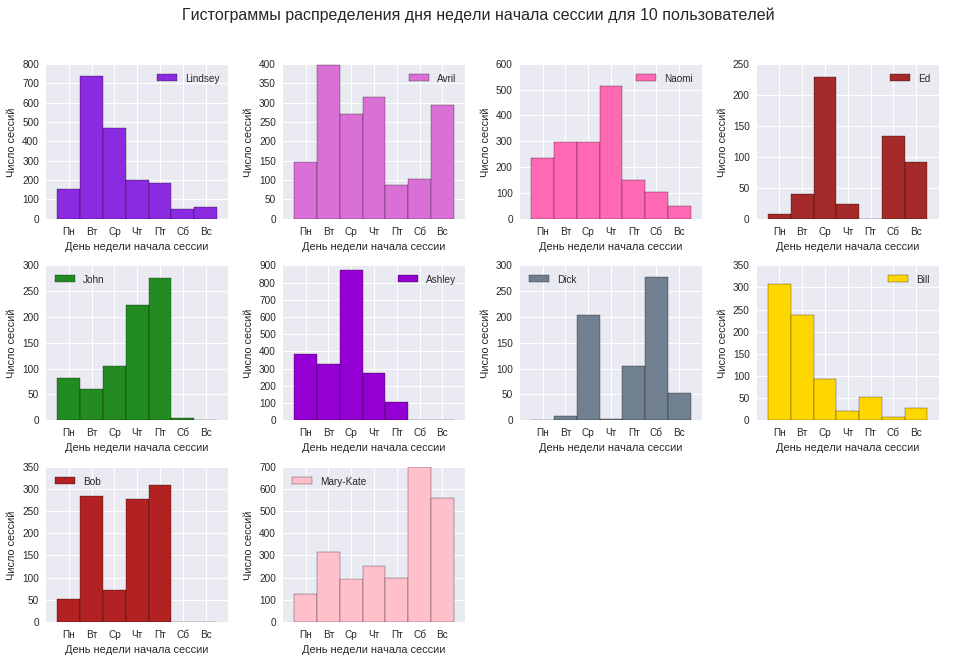

In [31]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.3)
user_names = id_name_dict.values()

for x, y in itertools.product(range(0, 3), range(0, 4)):
    if len(user_names):
        user_name = user_names.pop()
        axes[x, y].set_xlabel(u'День недели начала сессии')
        axes[x, y].set_ylabel(u'Число сессий')
        axes[x, y].set_xticklabels([u'Пн', u'Вт', u'Ср', u'Чт', u'Пт', u'Сб', u'Вс'])
        counts = np.bincount(train_data_10users[train_data_10users.target == user_name]['day_of_week'].astype(int),\
                             minlength=7)
        axes[x, y].bar(range(7), counts, width=1, align='center', color=color_dic[user_name], label=user_name)
        axes[x, y].set(xticks=range(7), xlim=[-1, 7])
        axes[x, y].legend(loc="best")
        
axes[2, 2].axis('off')
axes[2, 3].axis('off')
pyplot.suptitle(u'Гистограммы распределения дня недели начала сессии для 10 пользователей', fontsize=16)
pyplot.show()

# как вариант, можно и по-другому
#for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'target')): 
     #''' ВАШ КОД ЗДЕСЬ '''

**8. Сделайте выводы про каждого пользователя по построенным графикам.**

<table>
<tr>
<td><b>Пользователь</b></td>
<td><b>Распределения числа уникальных сайтов в сессии</b></td>
<td><b>Распределения часа начала сессии</b></td>
<td><b>Распределения дня недели начала сессии</b></td>
</tr>
<tr>
<td><b>Lindsey</b></td>
<td>Распределение числа уникальных сайтов выглядит вполне нормально-распределённым со средним числом уникальных сайтов в районе 6.</td>
<td>Посещает сайты в основном в середине дня, а также утром.</td>
<td>Посещает сайты в основном в середине недели, во вторник и в среду. В другие дни недели посещений сайтов существенно меньше, с минимальным количеством на выходных.</td>
</tr>

<tr>
<td><b>Avrill</b></td>
<td>Распределение числа уникальных сайтов выглядит вполне нормально-распределённым со средним числом уникальных сайтов в районе 6.</td>
<td>Посещает сайты целый день, пик приходится на середину дня.</td>
<td>Посещает сайты преимущественно по вторникам, средам, четвергам и воскресеньям.</td>
</tr>

<tr>
<td><b>Naomi</b></td>
<td>Распределение числа уникальных сайтов выглядит вполне нормально-распределённым со средним числом уникальных сайтов в районе 6.</td>
<td>Сидит в интеренте в основном с 12 до 17.</td>
<td>По возрастающей посещает сайты до четверга, затем резко сокращает посещения с пятницы по воскресенье.</td>
</tr>

<tr>
<td><b>Ed</b></td>
<td>Распределение скошено вправо, для них средее число уникальных сайтов приходится на 7-8.</td>
<td>Сидит в интернете практически целый день с пиком на обед и во второй половине дня.</td>
<td>Вообще не сидит в интернете по пятницам. Основной траффик приходится на среду, субботу и воскресенье.</td>
</tr>

<tr>
<td><b>John</b></td>
<td>Распределение скошено вправо, для них средее число уникальных сайтов приходится на 7-8.</td>
<td>Практически не сидит в интернете по вечерам, пик приходится с 11 до 17.</td>
<td>Посещает сайты в течение рабочей неделе по возрастающей, с пиком в пятницу и минимумом во вторник. На выходные приходится минимальное количество посещённых сайтов.</td>
</tr>

<tr>
<td><b>Ashley</b></td>
<td>Распределение скошено вправо, для них средее число уникальных сайтов приходится на 7-8.</td>
<td>Посещает сайты в основном с 8 до 16, с пиком по утрам.</td>
<td>Существенно чаще посещает сайты по средам, а по выходным вообще не сидит в интернете.</td>
</tr>

<tr>
<td><b>Dick</b></td>
<td>Число уникальных сайтов в сессии распределено более менее ровно, с пиком приходящимся на 2 сайта.</td>
<td>Сидит в интернете целый день с некоторыми всплесками активности в 9, 16, 21 часов.</td>
<td>В будни посещает сайты практически только по средам и пятницам. Из выходных, на субботу приходится максимум посещений.</td>
</tr>

<tr>
<td><b>Bill</b></td>
<td>Распределение скошено вправо, для них средее число уникальных сайтов приходится на 7-8.</td>
<td>Посещает сайты преимущественно в 8, 15, 18 часов. На остальное время приходится минимум.</td>
<td>Посещает сайты преимущественно в первые три дня недели. В остальные дни недели намного реже.</td>
</tr>

<tr>
<td><b>Bob</b></td>
<td>Распределение числа уникальных сайтов выглядит вполне нормально-распределённым со средним числом уникальных сайтов в районе 6.</td>
<td>Посещает сайты с 8 до 18 с небольшим уменьшением посещений с 12 до 14.</td>
<td>Посещает сайты только по будням, с максимумом во вторник, четверг и пятницу.</td>
</tr>

<tr>
<td><b>Mary-Kate</b></td>
<td>Распределение скошено влево со средним числом уникальных сайтов 3-5.</td>
<td>Посещает сайты целый день, с 8 до 23, со всплеском активности около 21 часа.</td>
<td>В будни посещает сайты более менее равномерно с небольшим снижением количества посещений в понедельник. На выходные приходится максимум траффика.</td>
</tr>
</table>

**Загрузите сохраненный ранее в pickle-файл частотный словарь сайтов для 10 пользователей. **

In [32]:
with open('capstone_websites_data/site_freq_10users.pkl', 'rb') as pkl_file:
    site_freq_10users = pickle.load(pkl_file)

In [33]:
sorted(site_freq_10users.items(), key=lambda t: t[1][1], reverse=True)[:10]

[('s.youtube.com', [176, 8300]),
 ('www.google.fr', [28, 7813]),
 ('www.google.com', [9, 5441]),
 ('mail.google.com', [3, 4158]),
 ('www.facebook.com', [45, 4141]),
 ('apis.google.com', [7, 3758]),
 ('r3---sn-gxo5uxg-jqbe.googlevideo.com', [177, 3244]),
 ('r1---sn-gxo5uxg-jqbe.googlevideo.com', [186, 3094]),
 ('plus.google.com', [8, 2630]),
 ('accounts.google.com', [1, 2089])]

**Определите топ-10 самых посещаемых сайтов (*top10_sites*) и соответствующие кол-ва посещений (*top10_freqs*).**

In [34]:
top10_freqs = [v[1] for k, v in sorted(site_freq_10users.items(), key=lambda t: t[1][1], reverse=True)[:10]]
top10_sites = [k for k, v in sorted(site_freq_10users.items(), key=lambda t: t[1][1], reverse=True)[:10]]

**9. Нарисуйте *seaborn barplot*, показывающий частоты посещений топ-10 сайтов. Сделайте подписи сайтов вертикальными, иначе они сливаются (*xticks*).**

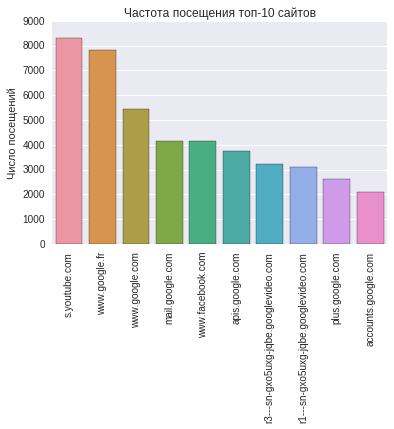

In [35]:
pyplot.ylabel(u'Число посещений')
pyplot.title(u'Частота посещения топ-10 сайтов')
ax = sns.barplot(top10_sites, top10_freqs)
pyplot.xticks(rotation='vertical')
pyplot.show()

## Часть 3. Дальнейшее построение признаков

Это задание творческое, тут надо придумать, как еще учесть время посещения веб-страниц и прочие признаки. 

На следующей неделе мы будем использовать "мешок" сайтов  для классификации сессий по принадлежности разным пользователям, а эти новые признаки, которые Вы сейчас создадите, потом добавим и посмотрим, улучшается ли модель. Поэтому можно их создать в виде отдельных матриц и сохранить их также отдельно.  

В этой части задания Вы можете построить и визуально исследовать самые разные признаки (ничто фантазию не ограничивает):
- время суток
- среднее время пребывания на сайте, посчитать можно, скажем, для топ-30 популярных сайтов
- индикаторы посещения популярных сайтов (скажем, тоже для топ-30 популярных сайтов)
- частота посещения Facebook
- ...

**Напишите функцию для создания новых признаков и примените ее к исходным данным – каталогам с 10 и 150 файлами. Сделайте это только для набора данных, полученного с параметрами *session_length=10* и *window_size=10*. Сериализуйте полученные матрицы с помощью pickle. Функция может возвращать как только новые признаки, так и старые с новыми. При этом сигнатура функции может быть другой – тут уже свобода выбора.**

In [45]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import tools
import plotly.graph_objs as go

init_notebook_mode(connected=True)

In [37]:
# Посмотрим на топ 30 сайтов
[k for k, v in sorted(site_freq_10users.items(), key=lambda t: t[1][1], reverse=True)[:30]]

['s.youtube.com',
 'www.google.fr',
 'www.google.com',
 'mail.google.com',
 'www.facebook.com',
 'apis.google.com',
 'r3---sn-gxo5uxg-jqbe.googlevideo.com',
 'r1---sn-gxo5uxg-jqbe.googlevideo.com',
 'plus.google.com',
 'accounts.google.com',
 'r2---sn-gxo5uxg-jqbe.googlevideo.com',
 'fr-mg42.mail.yahoo.com',
 'www.youtube.com',
 'r4---sn-gxo5uxg-jqbe.googlevideo.com',
 'clients1.google.com',
 'download.jboss.org',
 's-static.ak.facebook.com',
 'static.ak.facebook.com',
 'i1.ytimg.com',
 'twitter.com',
 'accounts.youtube.com',
 'platform.twitter.com',
 'safebrowsing-cache.google.com',
 'clients6.google.com',
 'translate.google.fr',
 'api.twitter.com',
 'accounts.google.fr',
 'talkgadget.google.com',
 'mts0.google.com',
 'clients2.google.com']

In [38]:
# Посмотрим на сайты, принадлежащие facebook
import re
regex=re.compile(".*(facebook).*")
[m.group(0) for l in site_freq_10users.keys() for m in [regex.search(l)] if m]

['static.ak.facebook.com',
 'api.facebook.com',
 'api-read.facebook.com',
 'www.facebook.com',
 'fr-fr.facebook.com',
 'developers.facebook.com',
 'apps.facebook.com',
 'badge.facebook.com',
 'fr.facebook.com',
 'static-0.facebook.com',
 'facebook.com',
 'ar-ar.facebook.com',
 'l.facebook.com',
 'static.ak.connect.facebook.com',
 'graph.facebook.com',
 'connect.facebook.net',
 's-static.ak.facebook.com']

In [39]:
def feature_engineering(csv_files_mask, site_freq_path, features,
                              session_length=10, window_size=10):
    
    train_data = np.array([np.zeros(len(features))])
    site_freq = {}
    
    if site_freq_path != "":
        pkl_file = open(site_freq_path, 'rb')
        site_freq = pickle.load(pkl_file)
    else:
        return None
    
    regex=re.compile(".*(facebook).*")
    facebook_ix = [site_freq[i][0] for i in [m.group(0) for l in site_freq.keys() for m in [regex.search(l)] if m]]
    regex=re.compile(".*(youtube).*")
    youtube_ix = [site_freq[i][0] for i in [m.group(0) for l in site_freq.keys() for m in [regex.search(l)] if m]]
    
    top30_ix = [v[0] for k, v in sorted(site_freq.items(), key=lambda t: t[1][1], reverse=True)[:30]]
    
    for userfile in glob(csv_files_mask):
        data = pd.read_csv(userfile, header=None, names=['userid', 'timestamp', 'site'], \
                           parse_dates=[1], infer_datetime_format=True)
        user_id = data.userid[0]
        session_hash = {}
        
        for i in range (0, len(data), window_size):
            session = tuple(data[i:i+session_length].site.apply(lambda x: site_freq[x][0]))           
            if session not in session_hash:
                session_hash[session] = 1
                session = list(session)
                
                timestamps = list(data[i:i+session_length].timestamp)
                time_diff = [(timestamps[n+1] - timestamps[n]).total_seconds() for n in range(0, len(session)-1)]
                session_timespan = (max(timestamps) - min(timestamps)).total_seconds()
                num_unique_sites = len(set(session))
                start_hour = min(timestamps).hour
                day_of_week = min(timestamps).weekday()
                
                #сайт, на котором пользователь находился дольше всего в сессии
                if len(session) == 1:
                    site_longest_time = session[0]
                else:
                    site_longest_time = session[time_diff.index(max(time_diff))]
                
                #доля facebook в сессии по времени
                facebook_in_session = np.where(np.in1d(session, facebook_ix) == True)[0]
                facebook_times = [time_diff[i] for i in facebook_in_session if i < len(time_diff)]
                fb_portion = sum(facebook_times)/session_timespan if len(facebook_times) else 0
                #print(facebook_in_session)
                
                #доля youtube в сессии по времени
                youtube_in_session = np.where(np.in1d(session, youtube_ix) == True)[0]
                youtube_times = [time_diff[i] for i in youtube_in_session if i < len(time_diff)]
                youtube_portion = sum(youtube_times)/session_timespan if len(youtube_times) else 0
                
                #доля топ30 сайтов в сессии по времени
                top30_in_session = np.where(np.in1d(session, top30_ix) == True)[0]
                top30_times = [time_diff[i] for i in top30_in_session if i < len(time_diff)]
                top30_portion = sum(top30_times)/session_timespan if len(top30_times) else 0
                
                #время суток начала сессии: 5-12 утро, 12-17 - день, 18-23 вечер, 0-5 ночь
                if start_hour in range(5,12):
                    daytime = 0
                elif start_hour in range(12, 18):
                    daytime = 1
                elif start_hour > 18:
                    daytime = 2
                elif start_hour < 5:
                    daytime = 3           
                
                session.extend([0] * (session_length - len(session)) + time_diff + \
                               [0]*(session_length - len(time_diff) - 1) + \
                               [session_timespan, num_unique_sites, site_longest_time, start_hour, day_of_week, daytime, fb_portion,\
                                youtube_portion, top30_portion, user_id])

                train_data = np.concatenate((train_data, np.array([session])))
    
    train_data = np.delete(train_data, 0, 0)
    train_data = pd.DataFrame(train_data, columns=feature_names)
    return train_data

In [40]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'site_longest_time', 'start_hour', 'day_of_week', 'daytime', 'fb_portion',\
                 'youtube_portion', 'top30_portion', 'target']
train_data_toy  = feature_engineering('capstone_websites_data/3users_toy/*', 
                                   site_freq_path='capstone_websites_data/site_freq_3users.pkl',
                                   features=feature_names, session_length=10)

In [41]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,...,time_diff8,time_diff9,session_timespan,#unique_sites,site_longest_time,start_hour,day_of_week,daytime,fb_portion,youtube_portion,top30_portion,target
0,1.0,2.0,3.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,287.0,1184.0,...,0.0,0.0,7935.0,3.0,3.0,9.0,4.0,0.0,0.0,0.0,1.0,2.0
1,1.0,2.0,2.0,4.0,2.0,5.0,6.0,7.0,8.0,9.0,287.0,1184.0,...,3.0,55.0,7998.0,8.0,2.0,9.0,4.0,0.0,0.0,0.0,1.0,1.0
2,1.0,5.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,3.0,...,0.0,0.0,60.0,2.0,5.0,12.0,4.0,1.0,0.0,0.0,1.0,1.0
3,10.0,5.0,2.0,5.0,2.0,5.0,5.0,7.0,11.0,10.0,287.0,1184.0,...,3.0,55.0,7998.0,5.0,2.0,9.0,4.0,0.0,0.0,0.0,1.0,3.0
4,10.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,287.0,1184.0,...,0.0,0.0,1471.0,3.0,5.0,12.0,4.0,1.0,0.0,0.0,1.0,3.0


In [42]:
%%time
new_features_10users = feature_engineering('capstone_websites_data/10users/*', 
                                   site_freq_path='capstone_websites_data/site_freq_10users.pkl',
                                   features=feature_names, session_length=10)

CPU times: user 10.8 s, sys: 0 ns, total: 10.8 s
Wall time: 10.8 s


In [517]:
%%time
new_features_150users = feature_engineering('capstone_websites_data/150users/*', 
                                   site_freq_path='capstone_websites_data/site_freq_150users.pkl',
                                   features=feature_names, session_length=10)

CPU times: user 4min 35s, sys: 4 ms, total: 4min 35s
Wall time: 4min 35s


**10. Постройте картинки для новых признаков, поисследуйте их, прокомментируйте результаты.**

In [43]:
new_features_10users['target'] = new_features_10users['target'].map(id_name_dict)

**Построим heatmap дня недели от времени суток как % от общего числа сессий для каждого из 10 пользователей.**

In [83]:
layout = go.Layout(
    title="Percentage of all user's sessions",
    height = 1300
)  

fig = tools.make_subplots(rows=5, cols=2, subplot_titles=(sorted(id_name_dict.values())),  print_grid=False,\
                         specs=[[{}, {}], [{}, {}], [{}, {}], [{}, {}], [{}, {}]], \
                         horizontal_spacing = 0.01, vertical_spacing = 0.07)

user_names = sorted(id_name_dict.values(), reverse=True)

for x, y in itertools.product(range(1, 6), range(1, 3)):
    if len(user_names):
        user_name = user_names.pop()

        userdata = new_features_10users[new_features_10users.target==user_name]\
                                            [["day_of_week", "daytime"]].\
                                            groupby(["day_of_week", "daytime"]).size().reset_index()
        matrix = []
        totalsessions = sum(userdata[0])
        for dtime in range(0,3):
            weekrow = []
            for day in range(0,7):
                value = userdata[(userdata.day_of_week == day) & (userdata.daytime == dtime)][0]
                if len(value):
                    weekrow.append(round(float(value) / totalsessions * 100, 1))
                else:
                    weekrow.append(0)
            matrix.append(weekrow)
        
        if y == 1:
            y_lable=['Morning', 'Afternoon', 'Evening']
        else:
            y_lable=[]
        
        data = go.Heatmap(
            z=matrix,
            x=['Mo', 'Tu', 'We', 'Th', 'Fr', 'Sa', 'Su'],
            y=y_lable,
            showscale=False,
            zsmooth="best"
        )

        fig.append_trace(data, x, y)
        
fig['layout'].update(layout)

iplot(fig)

***У каждого пользователя наблюдается свой паттерн пользования интернетом в течение недели и дня. В принципе, то же самое мы наблюдали и на гистограммах, но с использованием heatmap разница между пользователями получилась гораздо нагляднее.***

**Теперь посмотрим кто сколько времени проводит в Facebook, Youtube, а также на Топ-30 сайтах.**

In [551]:
trace1 = go.Bar(
    x=sorted(id_name_dict.values()),
    y=[round(np.mean(new_features_10users[(new_features_10users.target==user) & \
                                          (new_features_10users.fb_portion > 0)]["fb_portion"]) * 100, 1) \
                                                            for user in sorted(id_name_dict.values())],
    name='Facebook'
)
trace2 = go.Bar(
    x=sorted(id_name_dict.values()),
    y=[round(np.mean(new_features_10users[(new_features_10users.target==user)& \
                                          (new_features_10users.youtube_portion > 0)]["youtube_portion"]) * 100, 1) \
                                                             for user in sorted(id_name_dict.values())],
    name='Youtube'
)

trace3 = go.Scatter(
    x=sorted(id_name_dict.values()),
    y=[round(np.mean(new_features_10users[(new_features_10users.target==user) & \
                                          (new_features_10users.top30_portion > 0)]["top30_portion"]) * 100, 1) \
                                                             for user in sorted(id_name_dict.values())],
    name="Top-30 Websites"
)

data = [trace1, trace2, trace3]
layout = go.Layout(
    title="Average % of time spent on websites within a session",
    barmode='group',
    yaxis=dict(
        title='% of time in session'
        )
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)

Очень хорошо заметны различия между пользователями. Так, например, мы окончательно убедились, что Mary-Kate, которая сидит в интернете днями напролёт, более чем 80% времени проводит на топ-30 cайтах, при этом более 90% времени она проводит на сайтах, принадлежащих Youtube и Facebook. Возможно, она домохозяйка, хотя непонятно, что она может успевать делать по дому :)

В то же время, у Ashley процент времени, проведённый в Facebook и Youtube составляет 25.7 и 10 соответственно. Она меньше всех по времени проводит на топ-30 сайтах - 41.5%. Учитывая, что она не сидит в интернете по вечерам и по выходным, можно предположить, что у неё более насыщенная жизнь. Ну или она предпочитает книги или телевизор :)

**Посмотрим, на каком сайте в сессии пользователи проводят больше всего времени.**

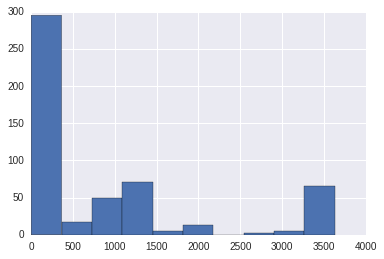

In [48]:
new_features_10users[new_features_10users.target == "Ed"]['site_longest_time'].hist()

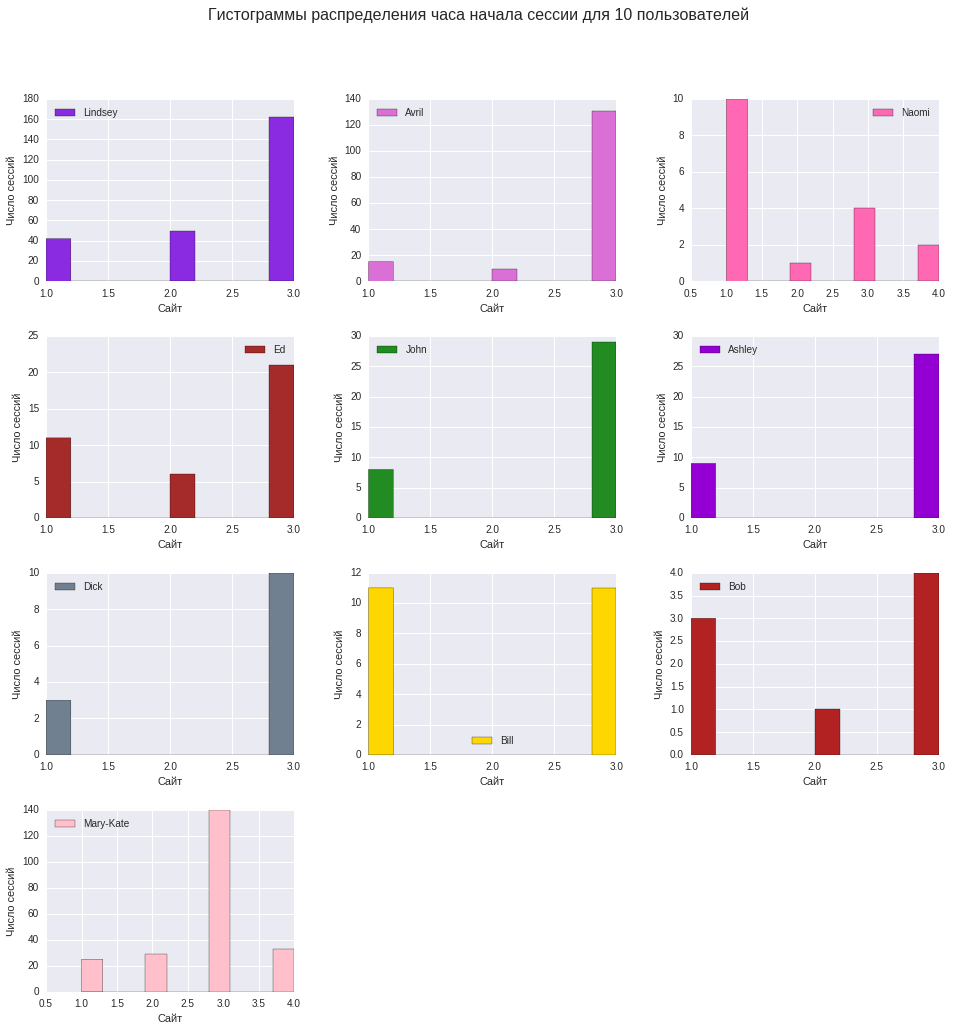

In [53]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(16, 16))
subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.3)
user_names = id_name_dict.values()

# возьмём одинаковые бины для всех гистограмм, чтобы удобнее было сравнивать
#hours = np.unique(new_features_10users['site_longest_time']).astype(int)
#bins = np.append(hours, hours[-1]+1) - 0.5 

for x, y in itertools.product(range(0, 4), range(0, 3)):
    if len(user_names):
        user_name = user_names.pop()
        axes[x, y].set_xlabel(u'Сайт')
        axes[x, y].set_ylabel(u'Число сессий')
        
        #new_features_10users[new_features_10users.target == user_name]['site_longest_time'].hist(color=color_dic[user_name],\
                                                                                    #ax=axes[x, y], label=user_name)
        
        new_features_10users[(new_features_10users.target == user_name) & \
                             (new_features_10users.site_longest_time < 5)]['site_longest_time'].hist(color=color_dic[user_name],\
                                                                                    ax=axes[x, y], label=user_name)
        
        #new_features_10users[new_features_10users.target == user_name]['site_longest_time'].hist(color=color_dic[user_name],\
                                                                                    #ax=axes[x, y], label=user_name,\
                                                                                     #bins = bins)
        #axes[x, y].set(xticks = hours, xlim = [min(hours)-1, max(hours)+1])
        
        axes[x, y].legend(loc="best")
axes[3, 1].axis('off')
axes[3, 2].axis('off')
pyplot.suptitle(u'Гистограммы распределения часа начала сессии для 10 пользователей', fontsize=16)
pyplot.show()

**В конце сохраните в pickle-файлы только те признаки, которые, как Вы предполагаете, помогут идентифицировать пользователя более точно. Это касается и признаков, которые мы вместе создали в начале (*session_timespan, time_diff1,..., time_diff9, #unique_sites, start_hour, day_of_week*), и Ваших собственных. Можно создать все эти признаки не только для сессий из 10 сайтов, но и для других сочетаний параметров *session_length* и *window_size*.**

Сохраним все сгенерированные признаки, потому что, на мой взгляд, все они помогут идентифицировать пользователя.

In [555]:
selected_features_10users = new_features_10users.iloc[:,10:-1]
selected_features_150users = new_features_150users.iloc[:,10:-1]

In [557]:
# selected features – among (session_timespan, ..., day_of_week) and your own new ones
with open('selected_features_10users.pkl', 'wb') as selected_features_10users_pkl:
    pickle.dump(selected_features_10users, selected_features_10users_pkl)
with open('selected_features_150users.pkl', 'wb') as selected_features_150users_pkl:
    pickle.dump(selected_features_150users, selected_features_150users_pkl)

## Критерии оценки работы:
- Верно ли отображена гистограмма session_timespan из п. 1? (max. 3 балла)
- Верно ли отображена гистограмма #unique_sites из п. 2? (max. 3 балла)
- Верно ли отображены гистограммы #unique_sites по каждому пользователю из п. 3? (max. 6 баллов)
- Верно ли отображена гистограмма start_hour из п. 4? (max. 3 балла)
- Верно ли отображены гистограммы start_hour по каждому пользователю из п. 5? (max. 6 баллов)
- Верно ли отображена гистограмма day_of_week из п. 6? (max. 3 балла)
- Верно ли отображены гистограммы day_of_week по каждому пользователю из п. 7? (max. 6 баллов)
- Насколько сделанные выводы в п. 8 соответствуют построенным картинкам? (max. 6 баллов)
- Верно ли отображен barplot для 10 популярных сайтов из п. 9? (max. 6 баллов)
- Есть ли оригинальные построенные признаки и картинки к ним? Оцените также и качество картинок. (max. 8 баллов)

## Пути улучшения
7 неделя проекта посвящена общему описанию проекта (.ipynb или pdf) и взаимному оцениванию. Что еще можно добавить по 3 части проекта:
- IPython-widgets, интерактив и анимация (стоящая [статья](https://habrahabr.ru/post/308162/) по этому ремеслу)
- можно попробовать изобразить исходные данные в некотором пространстве, например, Word2Vec, потом выделить главные компоненты или t-SNE  (только пользуйтесь эффективными реализациями, не Sklearn) и раскрасить по целевому классу. Но нет гарантий, что получится что-то значимо отличающееся от каши

Далее пройдите чисто техническое задание "Проверка построенных признаков", цель которого – удостовериться, что все мы одинаково создали признаки *session_timespan, time_diff1,..., time_diff9, #unique_sites, start_hour* и *day_of_week*.